## Description

**Dataset**

Each example is a random pair of MNIST digits placed at random positions within a large black image, with the target label of the sum of the MNIST digits.

**Model**

A CNN over the entire image. Serves as baseline where entire image is visible.



## Install

In [1]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
import torchvision
from torchvision import transforms

%load_ext autoreload
%autoreload 2

def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

## Config

In [3]:
debug = False
device = th.device('cuda' if th.cuda.is_available() and not debug else 'cpu')
print(f'Using {device}')

# Synthetic dataset
width = 128
height = 128
num_images = 50000
num_images_test = 10000
tiles_per_image = 2
num_classes = 1 + 9 * tiles_per_image  # [0, ..., 9 * n]

num_epochs = 10
batch_size = 32
learning_rate = 0.001

Using cuda


## Dataset: MNIST Pair Sum 

In [0]:
from rl.core.envs import synthetic_dataset

train_dataset = synthetic_dataset.MnistSyntheticDataset(
    width=width, height=height, num_images=num_images,
    tiles_per_image=tiles_per_image, train=True)

train_loader = th.utils.data.DataLoader(
    dataset=train_dataset, batch_size= batch_size, shuffle=True)

test_dataset = synthetic_dataset.MnistSyntheticDataset(
    width=width, height=height, num_images=num_images_test,
    tiles_per_image=tiles_per_image, train=False)

test_loader = th.utils.data.DataLoader(
    dataset=test_dataset, batch_size= batch_size, shuffle=False)

## Model (CNN)

In [0]:
from rl.core.algs import model

# Convolutional neural network.
class CNN(nn.Module):
  def __init__(self, num_outputs):
    super().__init__()
    
    self.convs = model.cnn([
        model.ConvSpec(depth=16, width=5, stride=2, padding=2),
        model.ConvSpec(32, 5, 2, 2),
        model.ConvSpec(64, 5, 2, 2),
        model.ConvSpec(128, 5, 2, 2),
        model.ConvSpec(256, 5, 2, 2),
        model.ConvSpec(512, 5, 2, 2),
    ], in_depth=1, fn=th.nn.ReLU, last_fn=th.nn.ReLU, bn=True)
    
    self.pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512, num_outputs)
    
  def forward(self, x):
    out = self.convs(x)
    out = self.pooling(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    return out

In [0]:
model = CNN(num_classes).to(device)

In [50]:
model

CNN(
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), p

## Train

In [51]:
from rl.core.algs import plotter

plotter = plotter.Plotter(log_dir='/tmp/tensorboard/synthetic_mnist_conv')

# Loss and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)


num_steps = len(train_loader)
for epoch in range(num_epochs):
  for step, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device, dtype=th.long)

    # Forward
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
      plotter.add_data('loss', epoch * num_steps + step,
                       loss.detach().cpu().numpy())

  print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'Loss: {loss.item():.4}')  

Epoch [1/10], Loss: 2.366
Epoch [2/10], Loss: 0.5574
Epoch [3/10], Loss: 0.8184
Epoch [4/10], Loss: 0.5054
Epoch [5/10], Loss: 0.264
Epoch [6/10], Loss: 0.08763
Epoch [7/10], Loss: 0.05684
Epoch [8/10], Loss: 0.08165
Epoch [9/10], Loss: 0.01006
Epoch [10/10], Loss: 0.06591


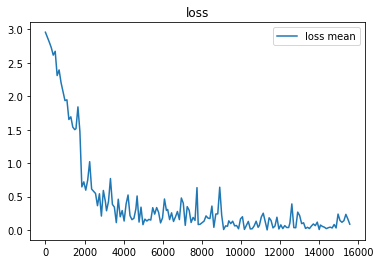

In [52]:
plotter.line_plot()

## Test

In [53]:
with th.no_grad():
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device, dtype=th.long)
    outputs = model(images)
    _, predicted = th.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Accuracy of model on {total} test images: {100 * accuracy:0.2f}%')

Accuracy of model on 10000 test images: 92.39%


In [54]:
with th.no_grad():
  correct, total = 0, 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device, dtype=th.long)
    outputs = model(images)
    _, predicted = th.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  print(f'Accuracy of model on {total} train images: {100 * accuracy:0.2f}%')

Accuracy of model on 50000 train images: 98.30%


## Visualize

In [0]:
with th.no_grad():
  images, labels = next(iter(test_loader))
  images, labels = images.to(device), labels.to(device, dtype=th.long)
  preds = model(images)

tensor(7, device='cuda:0') tensor(7, device='cuda:0')
tensor([-16.1596,  -4.9478,  -6.9536,  -7.7679,  -7.7037,  -0.1317,  -2.5946,
          8.0562,  -2.0000,  -3.7780,  -2.9590,  -9.3767,  -5.6192,  -5.8592,
        -15.6811,  -8.6717, -22.0356, -32.1228, -32.6468], device='cuda:0')


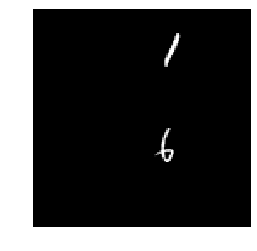

In [56]:
show_image(images[0].cpu())
print(labels[0], th.argmax(preds[0]))
print(preds[0])

tensor(11, device='cuda:0') tensor(11, device='cuda:0')
tensor([-39.6754, -30.5197, -19.6240,  -6.8789, -11.3518,  -6.5276,  -1.3963,
        -12.9377,  -8.8694,  -1.5018,  -2.5274,  12.1263,  -8.9412, -13.2299,
        -14.2734, -18.0063,  -5.6969,  -8.9192, -18.2917], device='cuda:0')


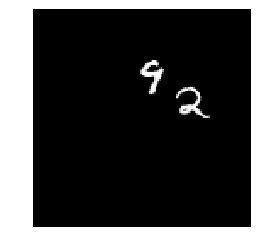

In [57]:
show_image(images[-1].cpu())
print(labels[-1], th.argmax(preds[-1]))
print(preds[-1])

## Save model

In [0]:
th.save(model.state_dict(), '/tmp/synthetic_mnist_conv.ckpt')